In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.3 MB/s eta 0:00:00


In [1]:
## import packages
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.simplefilter('ignore')

In [13]:
## load data
train = pl.read_csv(r'playground-series-s4e7\train.csv')
test = pl.read_csv(r'playground-series-s4e7\test.csv')
test = test.with_columns(pl.lit(0).cast(pl.Int64).alias('Response'))

In [3]:
# 원본 데이터를 복제하여 변환 작업을 수행
train_copy = train.clone()

# 열 변환
train_copy = train_copy.with_columns([
    pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
    pl.col('Region_Code').cast(int),
    pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
    pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
    pl.col('Annual_Premium').cast(int),
    pl.col('Policy_Sales_Channel').cast(int)
])

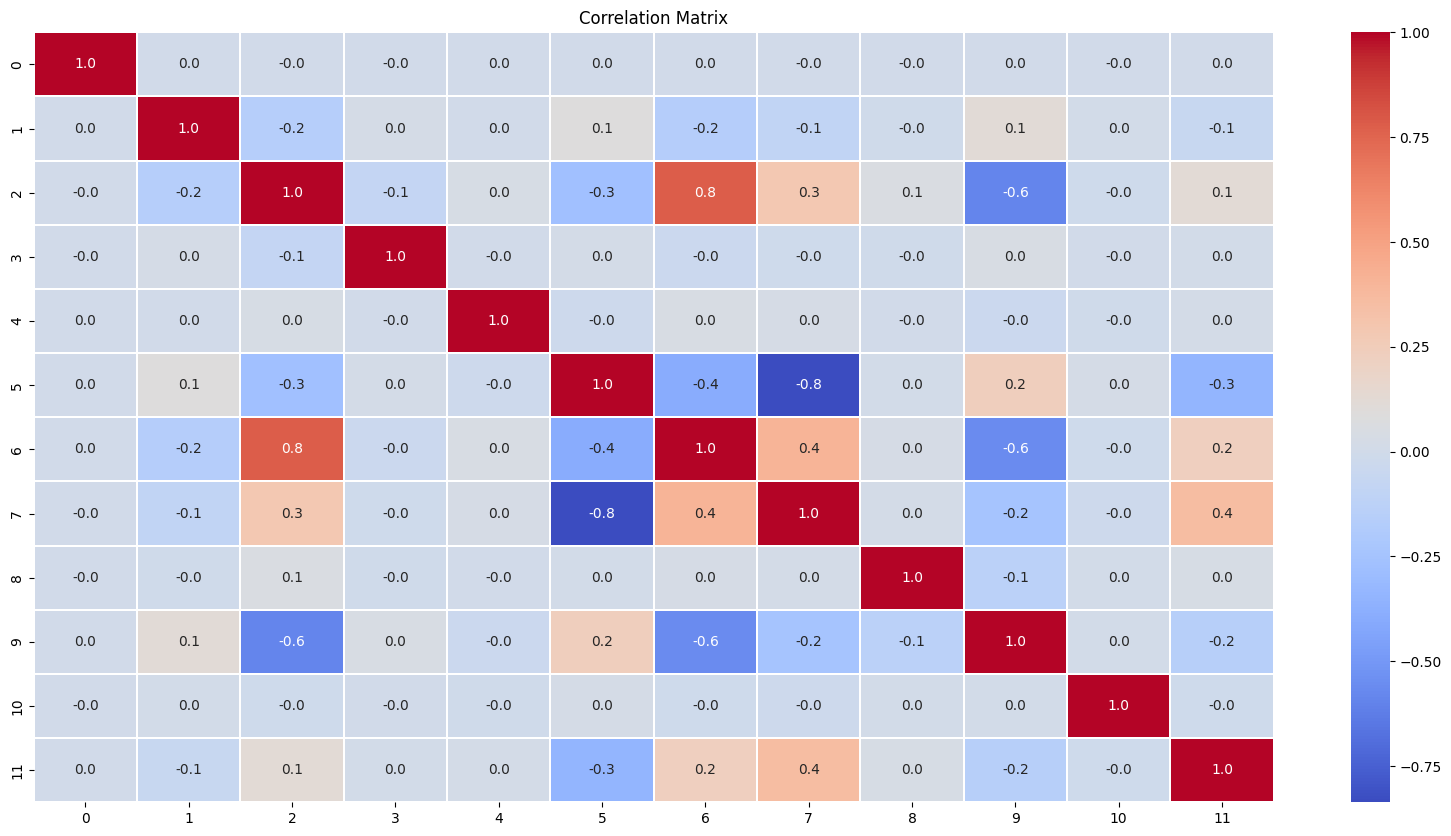

In [4]:
correlation_matrix = train_copy.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
#plt.gcf().set_facecolor('skyblue')
plt.title('Correlation Matrix')
plt.show()

In [20]:

# 기본 데이터 변환 함수
def basic_transform(df):
    return df.with_columns([
        pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
        pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
        pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
        pl.col('Region_Code').cast(pl.Int32),
        pl.col('Policy_Sales_Channel').cast(pl.Int32),
        pl.col('Annual_Premium').cast(pl.Float32),
        pl.col('Driving_License').cast(pl.Int32),
        pl.col('Previously_Insured').cast(pl.Int32)
    ])

# 데이터 복제
train_copy = train.clone()
test_copy = test.clone()

# 데이터 변환 적용
train_data = basic_transform(train_copy)
test_data = basic_transform(test_copy)

# 데이터 결합
df = pl.concat([train_data, test_data])

# 상호작용 피처 생성
df = df.with_columns([
    (pl.col('Age') * pl.col('Annual_Premium')).alias('Age_Premium_Interaction'),
    (pl.col('Policy_Sales_Channel') * pl.col('Region_Code')).alias('Policy_Region_Interaction'),
    (pl.col('Vehicle_Age') * pl.col('Driving_License')).alias('Vehicle_Age_License_Interaction'),
    (pl.col('Vehicle_Age') * pl.col('Vehicle_Damage')).alias('Vehicle_Age_Damage_Interaction'),
    (pl.col('Vehicle_Age') * pl.col('Region_Code')).alias('Region_Code_Vage_Interaction')
])

# 비선형 변환
df = df.with_columns([
    pl.col('Annual_Premium').log1p().alias('Log_Annual_Premium')
])

# # 그룹 기반 통계 피처 생성
# region_avg_premium = df.groupby('Region_Code').agg(pl.mean('Annual_Premium').alias('Region_Avg_Premium'))
# df = df.join(region_avg_premium, on='Region_Code')

# Pandas DataFrame으로 변환하여 K-평균 클러스터링 수행
df_pandas = df.to_pandas()

# K-평균 클러스터링
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_pandas[['Log_Annual_Premium', 'Vintage']])
df_pandas['Cluster'] = kmeans.labels_

# 다시 Polars DataFrame으로 변환
df = pl.from_pandas(df_pandas)

# 데이터를 다시 train과 test로 분할
train_df = df[:len(train_data)]
test_df = df[len(train_data):]

# 불필요한 열 제거
train_df = train_df.drop(['Annual_Premium'])
test_df = test_df.drop(['Annual_Premium'])

train_df

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Response,Age_Premium_Interaction,Policy_Region_Interaction,Vehicle_Age_License_Interaction,Vehicle_Age_Damage_Interaction,Region_Code_Vage_Interaction,Log_Annual_Premium,Cluster
i64,i32,i64,i32,i32,i32,i32,i32,i32,i64,i64,f64,i32,i32,i32,i32,f32,i32
0,0,21,1,35,0,1,1,124,187,0,1.367121e6,4340,1,1,35,11.083711,0
1,0,43,1,28,0,2,1,26,288,1,2.533173e6,728,2,2,56,10.9838,4
2,1,25,1,14,1,0,0,152,254,0,951075.0,2128,0,0,0,10.546498,4
3,1,35,1,1,0,1,1,156,76,0,92050.0,156,1,1,1,7.875119,1
4,1,36,1,15,1,1,0,152,294,0,1.150236e6,2280,1,0,15,10.37199,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11504793,0,48,1,6,0,1,1,26,218,0,1.315776e6,156,1,1,6,10.218773,0
11504794,1,26,1,36,0,0,1,152,115,1,767234.0,5472,0,0,0,10.292484,1
11504795,1,29,1,32,1,0,0,152,189,0,76270.0,4864,0,0,0,7.875119,0


In [ ]:
## train model
aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Response'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in ['id', 'Response']]]
    y_train = train.loc[train_idx, 'Response']
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, 'Response']
    X_test = test[X_train.columns]

    X_train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=X_valid.columns.values)
    X_test_pool = Pool(X_test, cat_features=X_test.columns.values)

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.05,
        iterations=5000,
        depth=9,
        random_strength=0,
        l2_leaf_reg=0.5,
        task_type='GPU',
        random_seed=42,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000, early_stopping_rounds=200)

    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}\n')

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8757758	best: 0.8757758 (0)	total: 799ms	remaining: 1h 6m 33s
1000:	test: 0.8946300	best: 0.8946300 (1000)	total: 14m 25s	remaining: 57m 39s
2000:	test: 0.8949861	best: 0.8949866 (1994)	total: 28m 41s	remaining: 42m 59s
3000:	test: 0.8950861	best: 0.8950871 (2993)	total: 43m	remaining: 28m 38s
4000:	test: 0.8951309	best: 0.8951325 (3957)	total: 57m 20s	remaining: 14m 19s
bestTest = 0.8951368332
bestIteration = 4189
Shrink model to first 4190 iterations.
Fold 1 AUC: 0.89514

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8751965	best: 0.8751965 (0)	total: 794ms	remaining: 1h 6m 7s
1000:	test: 0.8942412	best: 0.8942412 (1000)	total: 14m 25s	remaining: 57m 36s
2000:	test: 0.8946090	best: 0.8946090 (1999)	total: 28m 33s	remaining: 42m 48s
3000:	test: 0.8947293	best: 0.8947300 (2982)	total: 42m 50s	remaining: 28m 32s
4000:	test: 0.8947675	best: 0.8947684 (3989)	total: 56m 57s	remaining: 14m 13s
bestTest = 0.8947761953
bestIteration = 4229
Shrink model to first 4230 iterations.
Fold 2 AUC: 0.89478

### Fold 3 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8754973	best: 0.8754973 (0)	total: 792ms	remaining: 1h 5m 58s
1000:	test: 0.8945488	best: 0.8945488 (1000)	total: 14m 24s	remaining: 57m 32s
2000:	test: 0.8948848	best: 0.8948848 (2000)	total: 28m 38s	remaining: 42m 55s
3000:	test: 0.8949862	best: 0.8949864 (2999)	total: 42m 55s	remaining: 28m 35s
bestTest = 0.8950245976
bestIteration = 3746
Shrink model to first 3747 iterations.
Fold 3 AUC: 0.89502

### Fold 4 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8751477	best: 0.8751477 (0)	total: 957ms	remaining: 1h 19m 44s
1000:	test: 0.8943317	best: 0.8943319 (999)	total: 14m 27s	remaining: 57m 45s
2000:	test: 0.8946844	best: 0.8946850 (1990)	total: 28m 41s	remaining: 42m 59s
3000:	test: 0.8947928	best: 0.8947928 (3000)	total: 42m 50s	remaining: 28m 32s
4000:	test: 0.8948307	best: 0.8948310 (3944)	total: 57m	remaining: 14m 14s
bestTest = 0.8948370516
bestIteration = 4174
Shrink model to first 4175 iterations.
Fold 4 AUC: 0.89484

### Fold 5 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8762398	best: 0.8762398 (0)	total: 794ms	remaining: 1h 6m 11s
1000:	test: 0.8950258	best: 0.8950258 (1000)	total: 14m 19s	remaining: 57m 15s
2000:	test: 0.8953809	best: 0.8953809 (1998)	total: 28m 30s	remaining: 42m 43s
3000:	test: 0.8954781	best: 0.8954783 (2999)	total: 42m 47s	remaining: 28m 30s
4000:	test: 0.8955048	best: 0.8955050 (3999)	total: 56m 57s	remaining: 14m 13s
bestTest = 0.8955051303
bestIteration = 4029
Shrink model to first 4030 iterations.
Fold 5 AUC: 0.89551


Overall AUC: 0.89506 +/- 0.00026


In [ ]:
## create submission
submission = test[['id']]
submission['Response'] = np.mean(preds, axis=0)

submission.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/insurance_selling/submission.csv', index=False)
submission

,id,Response
0,11504798,0.004739
1,11504799,0.667146
2,11504800,0.237916
3,11504801,0.000084
4,11504802,0.246370
...,...,...
7669861,19174659,0.197856
7669862,19174660,0.000147
7669863,19174661,0.000491
7669864,19174662,0.589127
